In [1]:
#=================================================test==========================================================
import os
import numpy as np
from scipy import ndimage
#from skimage.transform import resize
#from scipy.ndimage import zoom
import nibabel as nib
from preprocess_20220927 import tprocess, sliding_inference

tbatch_size = 1
test_image_path = 'path that save the test data'
test_save_folder = 'prediction_site'
test_site = 'name_test_site'

base_path = 'directory to save model'
model_folder = 'model_folder_name'

mpath = os.path.join(base_path, model_folder)
if os.path.isfile(os.path.join(mpath,'keras_M4_minTrLoss.h5')):
    model_name = 'keras_M4_minTrLoss.h5' #model_name
elif os.path.isfile(os.path.join(mpath,'keras_M4.h5')):
    model_name = 'keras_M4.h5'
else:
    model_name = 'round_200_global.h5'
tlabel = []
tpath = []
tpatients = []

inplane_size = 256
slice_num = 64
if 'bi' in model_folder:
    biparametric = True
    input_channel_num = 2
elif 'single' in model_folder:
    biparametric = False
    input_channel_num = 1

k = os.listdir(test_image_path)
for j in k:
    tpath.append(test_image_path + '/' + j)    
    tpatients.append(j)

In [3]:
import keras.backend as K
from keras.models import *
from keras.losses import *
from keras.optimizers import Adam

if 'tf210' in model_folder:
    from M4modelGnRes210 import build_model
else:    
    from M4modelGnRes import build_model
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy('mixed_float16')

from keras.callbacks import ModelCheckpoint, EarlyStopping

os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

os.makedirs(os.path.join(mpath,test_save_folder), exist_ok=True)

model = build_model(input_shape=(None, None, None, input_channel_num), output_channels=1)
model.load_weights(os.path.join(mpath,model_name))

test_dice = []
test_sen = []
test_pre = []
for ind in range(len(tpath)):
    img, gt = tprocess(tpath[ind], biparametric)
    val = sliding_inference(img, model, inplane_size, slice_num)    
    
    val[val>=0.5] = 1
    val[val<0.5] = 0    
    gt[np.where(np.isnan(gt))] = 0
    val[np.where(np.isnan(val))] = 0
    for s in range(val.shape[-1]):
        val[:,:,s] = ndimage.binary_fill_holes(val[:,:,s])
    
    intersection = intersection = np.sum(gt * val)
    dice = (2. * intersection + 1e-8) / (np.sum(gt) + np.sum(val) + 1e-8)
    sen = (intersection + 1e-8) / (np.sum(gt) + 1e-8)
    pre = (intersection + 1e-8) / (np.sum(val) + 1e-8)
    print(tpath[ind], dice)
    test_sen.append(sen)    
    test_dice.append(dice)
    test_pre.append(pre)
    
    if 'AN' in tpath[ind]:
        tumor_type = 'AN'        
    if 'Men' in tpath[ind]:
        tumor_type = 'Mena'
    if 'Met' in tpath[ind]:
        tumor_type = 'Mets'
    tmp_pid = tpath[ind].split('/')[-1]
    pid = tmp_pid[:-4]
    
    if tumor_type == 'AN':
        nii_mimg_path = os.path.join('/mnt/d/M4/ZZc' , pid[3:], 'axc', 'mimg.nii')
    elif tumor_type == 'Mena':        
        nii_mimg_path = os.path.join('/mnt/f/Meningioma/20210402' , pid[5:], 'axc', 'mimg.nii')
    elif tumor_type == 'Mets':   
        nii_mimg_path = os.path.join('/mnt/e/Metastasis/20211128' , pid[5:], 'axc', 'mimg.nii')
        
    affine = nib.load(nii_mimg_path).affine
    imgp = nib.Nifti1Image(np.rot90(val, 3), affine)
    nib.save(imgp,os.path.join('build',mpath,test_save_folder,pid +'.nii.gz'))
    
print(np.median(test_dice))
print(np.median(test_sen))
print(np.median(test_pre))

import pandas as pd    
df = pd.DataFrame({'path': tpatients,
                   'dice': test_dice,
                   'sensitivity': test_sen,
                   'precision': test_pre,
                  })
writer = pd.ExcelWriter(os.path.join(mpath, 'Test_dice_'+test_site+'.xlsx'))
df.to_excel(writer,'Sheet1',index=False)
writer.close()

2024-02-16 08:16:23.118953: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-16 08:16:23.123772: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-16 08:16:23.124023: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-16 08:16:23.128025: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-16 08:16:23.128470: I tensorflow/compile

/mnt/f/20220309_process4FL/TVGH/brain_tumor_nomask_biparametric_twcc4/test/AN_1305833010.npz 0.8847457627123527
/mnt/f/20220309_process4FL/TVGH/brain_tumor_nomask_biparametric_twcc4/test/AN_1305845000.npz 0.8512035010957198
/mnt/f/20220309_process4FL/TVGH/brain_tumor_nomask_biparametric_twcc4/test/AN_1305847000.npz 0.9008830976348416
/mnt/f/20220309_process4FL/TVGH/brain_tumor_nomask_biparametric_twcc4/test/AN_1305870000.npz 0.8862522568999581
/mnt/f/20220309_process4FL/TVGH/brain_tumor_nomask_biparametric_twcc4/test/AN_1405893010.npz 0.9017998105465683
/mnt/f/20220309_process4FL/TVGH/brain_tumor_nomask_biparametric_twcc4/test/AN_1405912010.npz 0.9125651418646061
/mnt/f/20220309_process4FL/TVGH/brain_tumor_nomask_biparametric_twcc4/test/AN_1405926010.npz 0.8549172346654829
/mnt/f/20220309_process4FL/TVGH/brain_tumor_nomask_biparametric_twcc4/test/AN_1405932000.npz 0.8839941262865787


KeyboardInterrupt: 

In [7]:
np.median(test_dice)

0.846217107213384

In [17]:
#=========================================visualize====================
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage import measure

test_image_path = 'F:/20220309_process4FL/TCVGH/brain_tumor_nomask_biparametric_twcc4/test'
test_save_folder = 'prediction_TCVGH'
test_site = 'TCVGH'

base_path = 'F:/20220309_process4FL/baseline_model/aug'
model_folder = 'M4Gn_tf26_patch256_64_bi_gendice_adamlr1e4_e100_minTrLoss_20220609_patch_aug_noresampling'
mpath = os.path.join(base_path, model_folder, test_save_folder)

k = os.listdir(mpath)
ind = 0
patient = k[ind]

img = np.load(os.path.join(test_image_path,patient))['x_standard']
gt = np.load(os.path.join(test_image_path,patient))['y_standard']
val = np.load(os.path.join(mpath,patient))['prediction']
th = 0.5
val[val<th] = 0
val[val>=th] = 1
gt[np.where(np.isnan(gt))] = 0
val[np.where(np.isnan(val))] = 0

31
31
AN_GK_0102.npz
0.7979669631537742 0.7370892018841059 0.869806094186432
426.0
361.0


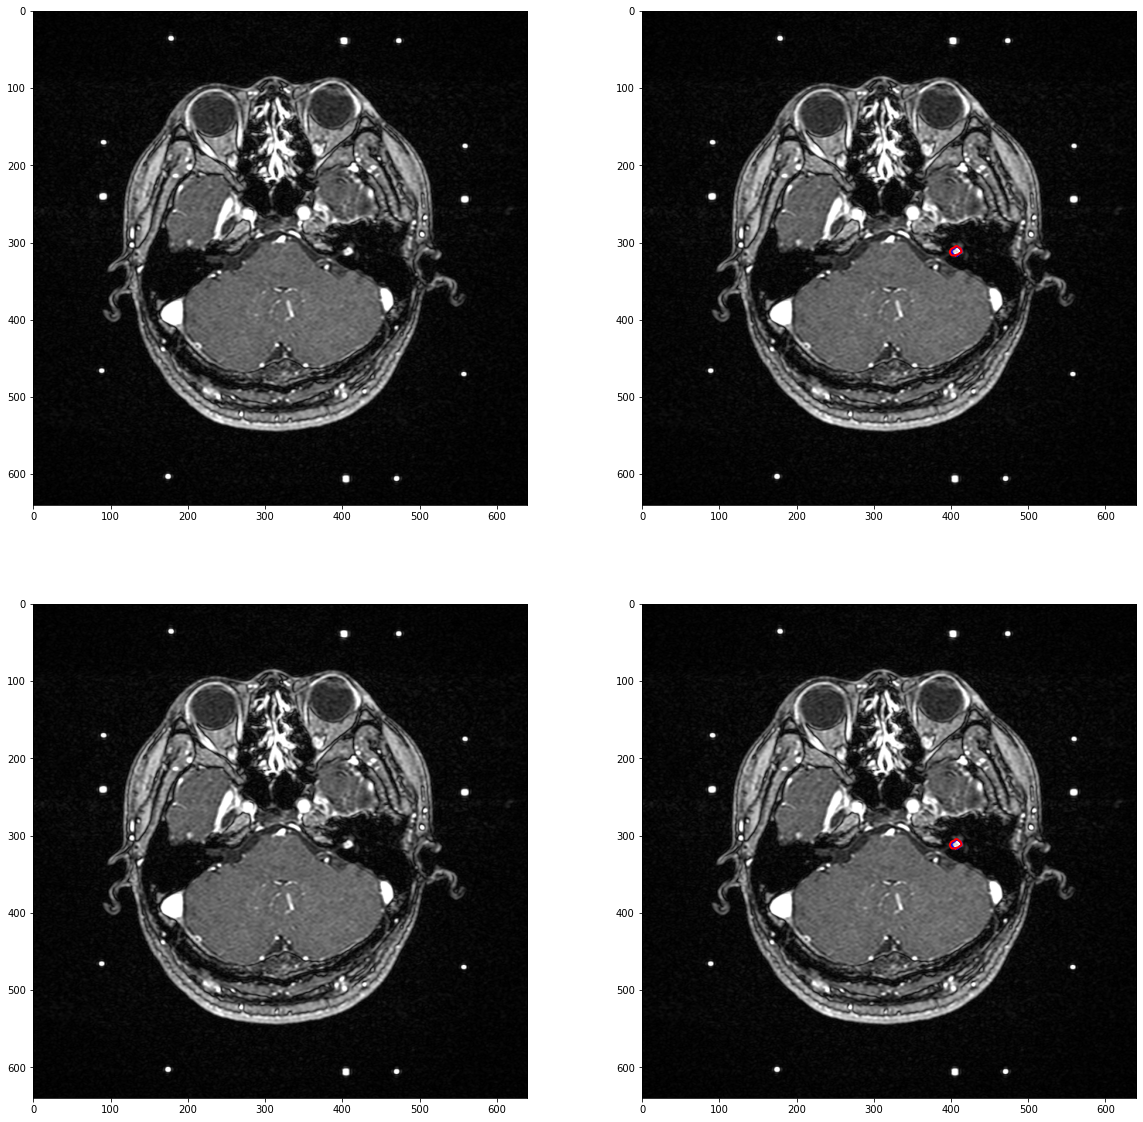

In [18]:
slice_sum = np.sum(gt,axis=(0,1))
slice_ind = np.argmax(slice_sum)
#slice_ind = 34
print(slice_ind)
contours = measure.find_contours(val[:,:,slice_ind], 0.5)
contours1 = measure.find_contours(gt[:,:,slice_ind], 0.5)
fig = plt.figure(figsize=[20,20])
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img[:,:,slice_ind,0],cmap='gray')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(img[:,:,slice_ind,0],cmap='gray')
for contour in contours:
    ax2.plot(contour[:, 1], contour[:, 0], 'b', linewidth=2)
for contour in contours1:
    ax2.plot(contour[:, 1], contour[:, 0], 'r', linewidth=2)

slice_sum = np.sum(val,axis=(0,1))
slice_ind = np.argmax(slice_sum)
print(slice_ind)
contours = measure.find_contours(val[:,:,slice_ind], 0.5)
contours1 = measure.find_contours(gt[:,:,slice_ind], 0.5)
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(img[:,:,slice_ind,0],cmap='gray')
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(img[:,:,slice_ind,0],cmap='gray')
for contour in contours:
    ax4.plot(contour[:, 1], contour[:, 0], 'b', linewidth=2)
for contour in contours1:
    ax4.plot(contour[:, 1], contour[:, 0], 'r', linewidth=2)

intersection = intersection = np.sum(gt * val)
dice = (2. * intersection + 1e-8) / (np.sum(gt) + np.sum(val) + 1e-8)
sen = (intersection + 1e-8) / (np.sum(gt) + 1e-8)
pre = (intersection + 1e-8) / (np.sum(val) + 1e-8)
print(k[ind])
print(dice,sen,pre)
print(np.sum(gt))
print(np.sum(val))

In [45]:
def tprocess(data_dir):
    data = np.load(data_dir)
    x = data['x_standard']
    y = data['y_standard']
    #upper = np.percentile(x, 99)
    #x[x > upper] = upper
    
    x = x[:,:,:,0]
    x = np.expand_dims(x, -1)
        
    if x.shape[0]<256 or x.shape[1]<256:
        x, y = padXY(x, y, padSize=256)
    #if x.shape[0] != x.shape[1]:
        #max_size = np.max(x.shape[:2])
        #x, y = padXY(x, y, padSize=max_size)
    
    inference_size = 256
    
    if x.shape[0] != inference_size:
        x = resize(x, [inference_size, inference_size, x.shape[2], x.shape[3]], order = 3)
    
    t1c_mean = np.mean(x[:,:,:,0])
    t1c_std = np.std(x[:,:,:,0])
    
    x = (x-t1c_mean)/t1c_std
        
    x = np.expand_dims(x, 0)
    return np.array(x,dtype=np.float32), y

4.0719620591829715


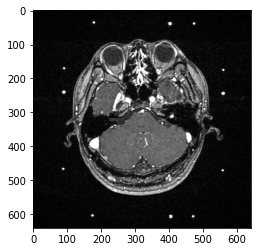

In [94]:
t1c = img[:,:,:,0]
t1c_mean = np.mean(t1c)
t1c_std = np.std(t1c)
t1c = (t1c-t1c_mean)/t1c_std
print(np.max(t1c))
plt.imshow(t1c[:,:,31],cmap='gray')

4.108903878002302


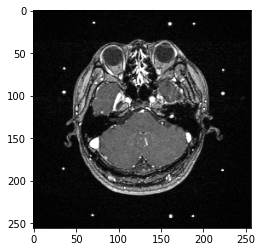

In [95]:
#from skimage.transform import resize
from scipy.ndimage import zoom
inference_size = 256
tmp = zoom(t1c, (inference_size/t1c.shape[0], inference_size/t1c.shape[0], 1), order=1)
#tmp = np.resize(t1c, (inference_size, inference_size, t1c.shape[2]))
tmp_mean = np.mean(tmp)
tmp_std = np.std(tmp)
tmp = (tmp-tmp_mean)/tmp_std
print(np.max(tmp))
plt.imshow(tmp[:,:,31],cmap='gray')

In [86]:
tmp.shape

(256, 256, 60)